In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [17]:
import selfsupmotion.zero_shot_pose as zsp
import numpy as np
zsp.use_cupy = False
experiment = "../output"
embeddings, info_df, train_embeddings, train_info_df = zsp.read_experiment(experiment)

def get_k_matches(idx, info_df, embeddings, train_info_df, train_embeddings, k_max=200, step=10, threshold=0.85):
    all_matches = []
    all_matches_idx = []
    for k in range(0,k_max,step):
        #print(k)
        match_idx, score = zsp.find_match_idx(idx, embeddings, train_embeddings,k, score=True)
        snapped, _ = zsp.get_match_snapped_points(idx, match_idx, info_df, train_info_df, rescale=True)
        #snapped, _ = zsp.get_match_aligned_points(idx, match_idx, info_df, train_info_df)
        if score < threshold and k!=0:
            break
        if not np.isnan(snapped[0][0]):
            all_matches.append(snapped)
            all_matches_idx.append(match_idx)
    return all_matches, all_matches_idx

In [18]:
from PIL import Image
idx=29161
k=0
threshold=0.85
match_idx = zsp.find_match_idx(idx, embeddings, train_embeddings,k)
match_idx

def get_min_l1_dist_box(all_matches_array):
    min_dist = 1e9
    min_dist_idx=0
    for i in range(len(all_matches_array)):
        l1_dist = (all_matches_array-all_matches_array[i]).sum()
        #print(i,l1_dist)
        if l1_dist<min_dist:
            #print(i)
            min_dist = l1_dist
            min_dist_idx = i
    return all_matches_array[min_dist_idx]

In [19]:
slider = widgets.IntSlider(min=0, max=10000, step=1, value=10)
plt.rcParams["figure.figsize"] = (15,5)
def f(x):
    idx =x 
    points_2d, point3d_query = zsp.get_points(info_df, idx)
    query_im=Image.open(info_df.iloc[idx]["filepath_full"])
    
    zsp.draw_bbox(query_im,zsp.points_2d_to_points2d_px(points_2d, query_im.width, query_im.height),line_color=(255,255,255))
    im = query_im.copy()
    camera = zsp.get_camera(info_df, idx)
    intrinsics = zsp.get_intrinsics(camera)
    intrinsics = zsp.scale_intrinsics(intrinsics, 0.25, 0.25)
    all_matches, all_matches_idx=get_k_matches(idx, info_df, embeddings, train_info_df, train_embeddings,
                                               k_max=40, step=5, threshold=0.85)
    #best_iou, match_idx = zsp.get_iou(idx, embeddings, info_df, train_embeddings, 
    #                                  train_info_df,k=0, symmetric=False, ground_plane=False, rescale=False)
    best_box = all_matches[0]
    best_iou = zsp.get_iou_between_bbox(point3d_query, best_box)
    train_im=Image.open(train_info_df.iloc[all_matches_idx[0]]["filepath_full"])
    points_2d, _ = zsp.get_points(train_info_df, all_matches_idx[0])
    zsp.draw_bbox(train_im,zsp.points_2d_to_points2d_px(points_2d, query_im.width, query_im.height),line_color=(255,255,255))
    
    points2d_px = zsp.project_3d_to_2d(best_box, intrinsics)
    zsp.draw_bbox(im,points2d_px)
    
    #mean_center= np.nanmean(np.array(all_matches),axis=0)[0]
    mean_box = np.nanmean(np.array(all_matches),axis=0)
    #mean_box=all_matches[0]-all_matches[0][0]+mean_center
    mean_box_iou = zsp.get_iou_between_bbox(point3d_query, mean_box)
    minl1_box = get_min_l1_dist_box(all_matches)
    minl1_box_iou = zsp.get_iou_between_bbox(point3d_query, minl1_box)
    #points2d_px = zsp.project_3d_to_2d(mean_box, intrinsics)
    #zsp.draw_bbox(im,points2d_px, line_color=(0,0,255))
    #points2d_px = zsp.project_3d_to_2d(minl1_box, intrinsics)
    #zsp.draw_bbox(im,points2d_px, line_color=(0,255,255))
    
    print(f"Best match IoU : {best_iou:0.2f}, Mean box IoU: {mean_box_iou:0.2f}, L1 box IoU: {minl1_box_iou:0.2f}")
    #display(im)
    #display(im)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(query_im)
    ax2.imshow(train_im)
    ax3.imshow(im)
    return x
interact(f, x=slider)

interactive(children=(IntSlider(value=10, description='x', max=10000), Output()), _dom_classes=('widget-intera…

<function __main__.f(x)>

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        #if image.ndim == 2:
        #    plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()


In [25]:
idx=3430
all_matches, all_matches_idx=get_k_matches(idx, info_df, embeddings, train_info_df, train_embeddings,
                                               k_max=40, step=5, threshold=0.85)

images = []
for idx in all_matches_idx[0:10]:
    train_im=Image.open(train_info_df.iloc[idx]["filepath_full"])
    points_2d, _ = zsp.get_points(train_info_df, idx)
    zsp.draw_bbox(train_im,zsp.points_2d_to_points2d_px(points_2d, train_im.width, train_im.height),line_color=(255,255,255))
    images.append(train_im)


<ipython-input-23-2a081985398a>:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


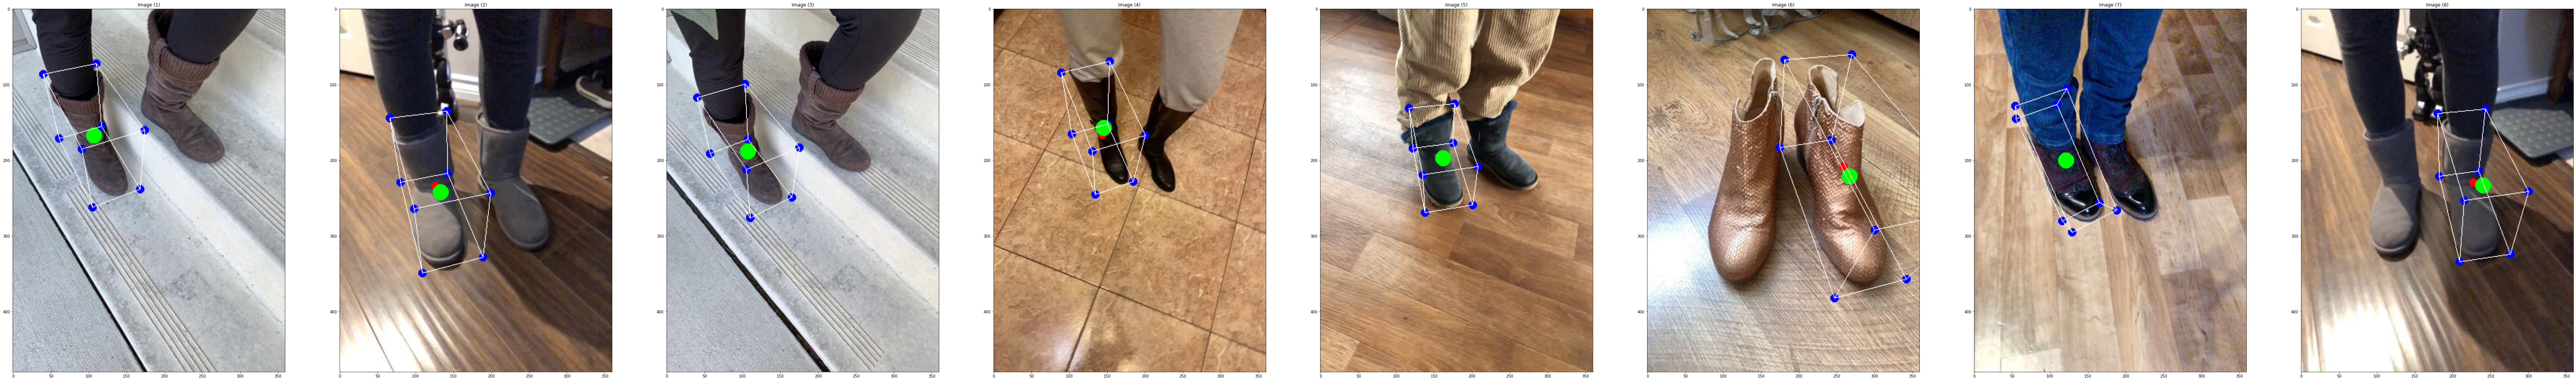

In [26]:
show_images(images)

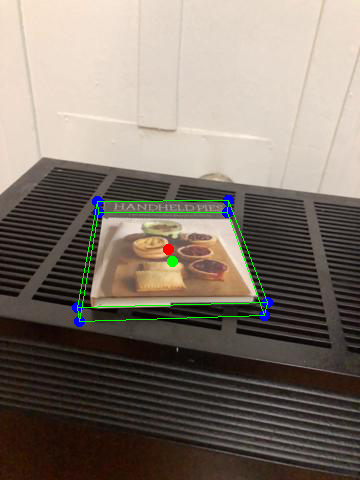

In [24]:
points_2d, point3d_query = zsp.get_points(info_df, idx)
im=Image.open(info_df.iloc[idx]["filepath_full"])
display(zsp.draw_bbox(im,zsp.points_2d_to_points2d_px(points_2d, im.width, im.height)))

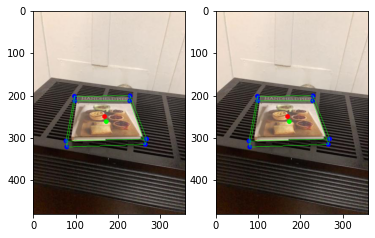

In [33]:
import matplotlib.pyplot as plt
plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im)
ax2.imshow(im)

In [36]:
train_im

NameError: name 'train_im' is not defined

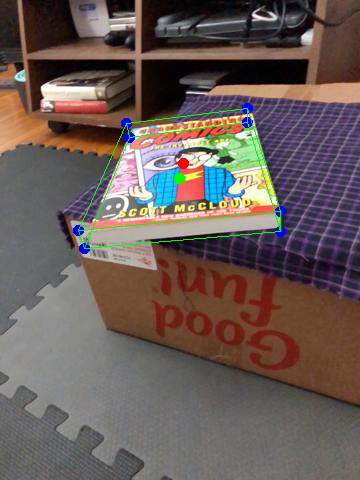

In [38]:
train_im=Image.open(train_info_df.iloc[match_idx]["filepath_full"])
points_2d, _ = zsp.get_points(train_info_df, match_idx)
zsp.draw_bbox(train_im,zsp.points_2d_to_points2d_px(points_2d, train_im.width, train_im.height))

In [59]:

camera = zsp.get_camera(info_df, idx)
intrinsics = zsp.get_intrinsics(camera)
intrinsics = zsp.scale_intrinsics(intrinsics, 0.25, 0.25)

    #print(score)

all_matches, all_matches_idx=get_k_matches(idx, info_df, embeddings, train_info_df, train_embeddings, k_max=200, step=10, threshold=0.85)
mean_box = np.nanmean(np.array(all_matches),axis=0) #Ignore errors
mean_box, len(all_matches)
all_matches

[array([[ 0.02481398, -0.00362977, -0.5127335 ],
        [-0.05042793,  0.0804715 , -0.61781891],
        [-0.05728934, -0.08337215, -0.61606555],
        [-0.03423294,  0.07968138, -0.62827579],
        [-0.04109436, -0.08416226, -0.62652249],
        [ 0.09072232,  0.07690273, -0.39894454],
        [ 0.08386091, -0.08694095, -0.39719119],
        [ 0.1069173 ,  0.07611262, -0.40940142],
        [ 0.10005589, -0.08773106, -0.40764807]]),
 array([[ 0.02529229, -0.01611153, -0.49418121],
        [-0.01223496,  0.05893238, -0.59263934],
        [-0.01184601, -0.1058961 , -0.5795824 ],
        [-0.04377801,  0.06047131, -0.57227247],
        [-0.04338906, -0.10435717, -0.55921553],
        [ 0.09397364,  0.07213411, -0.42914694],
        [ 0.0943626 , -0.09269437, -0.41608998],
        [ 0.06243059,  0.07367306, -0.40878006],
        [ 0.06281954, -0.09115544, -0.39572312]]),
 array([[ 0.02579013, -0.01521731, -0.49353507],
        [-0.01146586,  0.06018324, -0.59154214],
        [-0.0114

In [61]:
all_matches_array = np.array(all_matches)
#center = np.mean(all_matches_array,axis=0)[0]
#all_matches_array_0 = all_matches_array - center
#mean_box = np.nanmedian(all_matches_array_0,axis=0) + center

all_matches_array

array([[[ 0.02481398, -0.00362977, -0.5127335 ],
        [-0.05042793,  0.0804715 , -0.61781891],
        [-0.05728934, -0.08337215, -0.61606555],
        [-0.03423294,  0.07968138, -0.62827579],
        [-0.04109436, -0.08416226, -0.62652249],
        [ 0.09072232,  0.07690273, -0.39894454],
        [ 0.08386091, -0.08694095, -0.39719119],
        [ 0.1069173 ,  0.07611262, -0.40940142],
        [ 0.10005589, -0.08773106, -0.40764807]],

       [[ 0.02529229, -0.01611153, -0.49418121],
        [-0.01223496,  0.05893238, -0.59263934],
        [-0.01184601, -0.1058961 , -0.5795824 ],
        [-0.04377801,  0.06047131, -0.57227247],
        [-0.04338906, -0.10435717, -0.55921553],
        [ 0.09397364,  0.07213411, -0.42914694],
        [ 0.0943626 , -0.09269437, -0.41608998],
        [ 0.06243059,  0.07367306, -0.40878006],
        [ 0.06281954, -0.09115544, -0.39572312]],

       [[ 0.02579013, -0.01521731, -0.49353507],
        [-0.01146586,  0.06018324, -0.59154214],
        [-0.0114

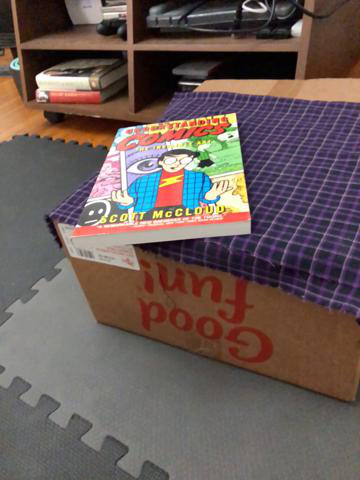

In [113]:
Image.open(train_info_df.iloc[all_matches_idx[min_dist_idx]]["filepath_full"])

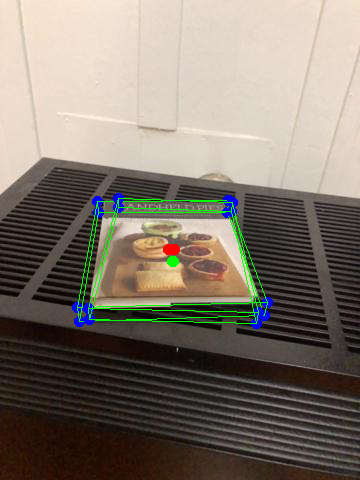

In [114]:
points2d_px = zsp.project_3d_to_2d(mean_box, intrinsics)
zsp.draw_bbox(im,points2d_px)


In [115]:
zsp.get_iou_between_bbox(point3d_query, mean_box)

0.5828896713352414

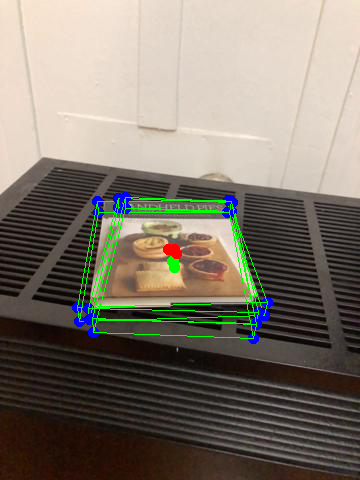

In [116]:
match_idx = zsp.find_match_idx(idx, embeddings, train_embeddings,0)
snapped, _ = zsp.get_match_snapped_points(idx, match_idx, info_df, train_info_df)
points2d_px = zsp.project_3d_to_2d(snapped, intrinsics)
zsp.draw_bbox(im,points2d_px)

In [117]:
all_matches

[array([[ 0.02481398, -0.00362977, -0.5127335 ],
        [-0.05042793,  0.0804715 , -0.61781891],
        [-0.05728934, -0.08337215, -0.61606555],
        [-0.03423294,  0.07968138, -0.62827579],
        [-0.04109436, -0.08416226, -0.62652249],
        [ 0.09072232,  0.07690273, -0.39894454],
        [ 0.08386091, -0.08694095, -0.39719119],
        [ 0.1069173 ,  0.07611262, -0.40940142],
        [ 0.10005589, -0.08773106, -0.40764807]]),
 array([[ 0.02529229, -0.01611153, -0.49418121],
        [-0.01223496,  0.05893238, -0.59263934],
        [-0.01184601, -0.1058961 , -0.5795824 ],
        [-0.04377801,  0.06047131, -0.57227247],
        [-0.04338906, -0.10435717, -0.55921553],
        [ 0.09397364,  0.07213411, -0.42914694],
        [ 0.0943626 , -0.09269437, -0.41608998],
        [ 0.06243059,  0.07367306, -0.40878006],
        [ 0.06281954, -0.09115544, -0.39572312]]),
 array([[ 0.02579013, -0.01521731, -0.49353507],
        [-0.01146586,  0.06018324, -0.59154214],
        [-0.0114

In [118]:
k=0
best_iou, match_idx = zsp.get_iou(idx, embeddings, info_df, train_embeddings, train_info_df,k=k, symmetric=False, rescale=True)
best_iou, match_idx, k 

(0.7145055391929485, 367684, 0)